In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ac3airborne
import typhon as ty
import src
from dotenv import load_dotenv
import scipy.stats

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


In [3]:
cat, meta, credentials, kwds = src.get_ac3_meta()

In [4]:
lwp_campaign_p5 = xr.open_dataset('/net/secaire/mringel/data/lwp_retrieved/all_campaigns_P5_lwp_v4.nc')
lwp_campaign_era5 = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/all_campaigns_ERA5_lwp_v2.nc')
lwp_campaign_aqua = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_modis/all_campaigns_P5_MODIS_aqua_lwp_v2.nc')
lwp_campaign_terra = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_modis/all_campaigns_P5_MODIS_terra_lwp_v2.nc')
lwp_campaign_amsr = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_amsr2/all_campaigns_P5_AMSR_lwp_v4.nc')

lwp_campaign_p5 = lwp_campaign_p5.dropna(dim='time')

era5_alongRFs = xr.open_mfdataset('/net/secaire/mringel/era5_alongFlights/ERA5_*_v2.nc')
lwp_campaign_era5['cell_ind'] = (('time'),era5_alongRFs.sel(time=lwp_campaign_era5.time,drop=True).cell_ind.values)

In [5]:
lwp_campaign_era5 = src.get_identical_times(lwp_campaign_era5,lwp_campaign_p5,drop_others=True)
lwp_campaign_aqua = src.get_identical_times(lwp_campaign_aqua,lwp_campaign_p5,drop_others=True)
lwp_campaign_terra = src.get_identical_times(lwp_campaign_terra,lwp_campaign_p5,drop_others=True)
lwp_campaign_amsr = src.get_identical_times(lwp_campaign_amsr,lwp_campaign_p5,drop_others=True)

#lwp_era5 = lwp_campaign_era5.lwp.values*1000
lwp_aqua = lwp_campaign_aqua.lwp.values
lwp_terra = lwp_campaign_terra.lwp.values
lwp_amsr = lwp_campaign_amsr.lwp.values*1000

lwp_terra[lwp_terra==-9999] = np.nan
lwp_aqua[lwp_aqua==-9999] = np.nan
lwp_amsr[lwp_amsr==-9999] = np.nan

mcao_daily = xr.open_mfdataset('/net/secaire/mringel/data/cwt_mcao_ind/mcao_*_v2.nc')
mcao_second = mcao_daily.resample(time='1S').pad()
mcao = mcao_second.sel(time=lwp_campaign_p5.time,drop=True)

### Manual grouping over ERA5 gridcell indices

In [6]:
era5_lwp = []
#era5_time = []

p5_lwp_mean = []
p5_lwp_std = []
p5_lwp_var = []
p5_lwp_min = []
p5_lwp_max = []
p5_mcao_mean = []

era5_cells = sorted(list(dict(lwp_campaign_era5.groupby(lwp_campaign_era5.cell_ind)).keys()))

for cell in era5_cells:

    era5_lwp_value = lwp_campaign_era5.where(lwp_campaign_era5.cell_ind==cell,drop=True).lwp.values[0]
    #era5_time_value = lwp_campaign_era5.where(lwp_campaign_era5.cell_ind==cell,drop=True).time.values[0]

    p5_lwp_values = lwp_campaign_p5.where(lwp_campaign_era5.cell_ind==cell,drop=True).lwp.values
    p5_time_values = lwp_campaign_p5.where(lwp_campaign_era5.cell_ind==cell,drop=True).time.values[0]

    # calculate statistics of all P5 measurements collocated to identical ERA5 gridcell
    p5_lwp_mean_j = np.nanmean(p5_lwp_values)
    p5_lwp_std_j = np.nanstd(p5_lwp_values)
    p5_lwp_var_j = np.nanvar(p5_lwp_values)
    p5_lwp_min_j = np.nanmin(p5_lwp_values)
    p5_lwp_max_j = np.nanmax(p5_lwp_values)
    p5_mcao_mean_j = np.nanmean(mcao.sel(time=p5_time_values,drop=True).MCAO.values)
    
    era5_lwp.append(era5_lwp_value)

    p5_lwp_mean.append(p5_lwp_mean_j)
    p5_lwp_std.append(p5_lwp_std_j)
    p5_lwp_var.append(p5_lwp_var_j)
    p5_lwp_min.append(p5_lwp_min_j)
    p5_lwp_max.append(p5_lwp_max_j)
    p5_mcao_mean.append(p5_mcao_mean_j)

era5_p5 = xr.Dataset(
    data_vars=dict(
        lwp_era5=(['era5_cell'],np.array(era5_lwp)),
        lwp_p5_mean=(['era5_cell'],np.array(p5_lwp_mean)),
        lwp_p5_std=(['era5_cell'],np.array(p5_lwp_std)),
        lwp_p5_var=(['era5_cell'],np.array(p5_lwp_var)),
        lwp_p5_min=(['era5_cell'],np.array(p5_lwp_min)),
        lwp_p5_max=(['era5_cell'],np.array(p5_lwp_max)),
        mcao_p5_mean=(['era5_cell'],np.array(p5_mcao_mean))
        ),
        coords=dict(
            era5_cell=np.array(era5_cells))
        )

### Manual grouping over AMSR2 gridcell indices

In [7]:
p5 = xr.open_dataset('/net/secaire/mringel/data/lwp_retrieved/all_campaigns_P5_lwp.nc')
amsr = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_amsr2/all_campaigns_P5_AMSR_lwp_v3.nc')

amsr_sel = src.get_identical_times(amsr,lwp_campaign_p5,drop_others=False)
all_amsr_cells = list(dict(amsr_sel.groupby(amsr_sel.cell)).keys())

amsr_sel = src.get_identical_times(amsr,lwp_campaign_p5,drop_others=True)
p5_sel = src.get_identical_times(p5,amsr_sel,drop_others=True)

amsr_lwp = []
amsr_time = []

p5_lwp_mean = []
p5_lwp_std = []
p5_lwp_var = []
p5_lwp_min = []
p5_lwp_max = []
p5_mcao_mean = []

amsr_cells = []

for cell in all_amsr_cells:

    amsr_time_j = amsr_sel.where(amsr_sel.cell==cell,drop=True).amsr_time_var.values[0]
    amsr_lwp_j = amsr_sel.where(amsr_sel.cell==cell,drop=True).lwp.values[0]

    p5_lwp_around_amsr_cell = p5_sel.where(amsr_sel.cell==cell,drop=True).lwp.values
    p5_time_values = p5_sel.where(amsr_sel.cell==cell,drop=True).time.values

    # calculate statistics of all P5 measurements collocated to identical AMSR2 gridcell
    if len(p5_lwp_around_amsr_cell) != 0:
        p5_lwp_mean_j = np.nanmean(p5_lwp_around_amsr_cell)
        p5_lwp_std_j = np.nanstd(p5_lwp_around_amsr_cell)
        p5_lwp_var_j = np.nanvar(p5_lwp_around_amsr_cell)
        p5_lwp_min_j = np.nanmin(p5_lwp_around_amsr_cell)
        p5_lwp_max_j = np.nanmax(p5_lwp_around_amsr_cell)
        p5_mcao_mean_j = np.nanmean(mcao.sel(time=p5_time_values,drop=True).MCAO.values)
    
        amsr_cells.append(cell)

        amsr_time.append(amsr_time_j)
        amsr_lwp.append(amsr_lwp_j)

        p5_lwp_mean.append(p5_lwp_mean_j)
        p5_lwp_std.append(p5_lwp_std_j)
        p5_lwp_var.append(p5_lwp_var_j)
        p5_lwp_min.append(p5_lwp_min_j)
        p5_lwp_max.append(p5_lwp_max_j)
        p5_mcao_mean.append(p5_mcao_mean_j)

# save to xr dataset
amsr_p5 = xr.Dataset(
    data_vars=dict(
        time_amsr=(['amsr_cell'],np.array(amsr_time)),
        lwp_amsr=(['amsr_cell'],np.array(amsr_lwp)),
        lwp_p5_mean=(['amsr_cell'],np.array(p5_lwp_mean)),
        lwp_p5_std=(['amsr_cell'],np.array(p5_lwp_std)),
        lwp_p5_var=(['amsr_cell'],np.array(p5_lwp_var)),
        lwp_p5_min=(['amsr_cell'],np.array(p5_lwp_min)),
        lwp_p5_max=(['amsr_cell'],np.array(p5_lwp_max)),
        mcao_p5_mean=(['amsr_cell'],np.array(p5_mcao_mean)),
        ),
        coords=dict(
            amsr_cell=np.array(amsr_cells))
        )

amsr_p5 = amsr_p5.where(amsr_p5.lwp_amsr != -9999)

### Sorted by product

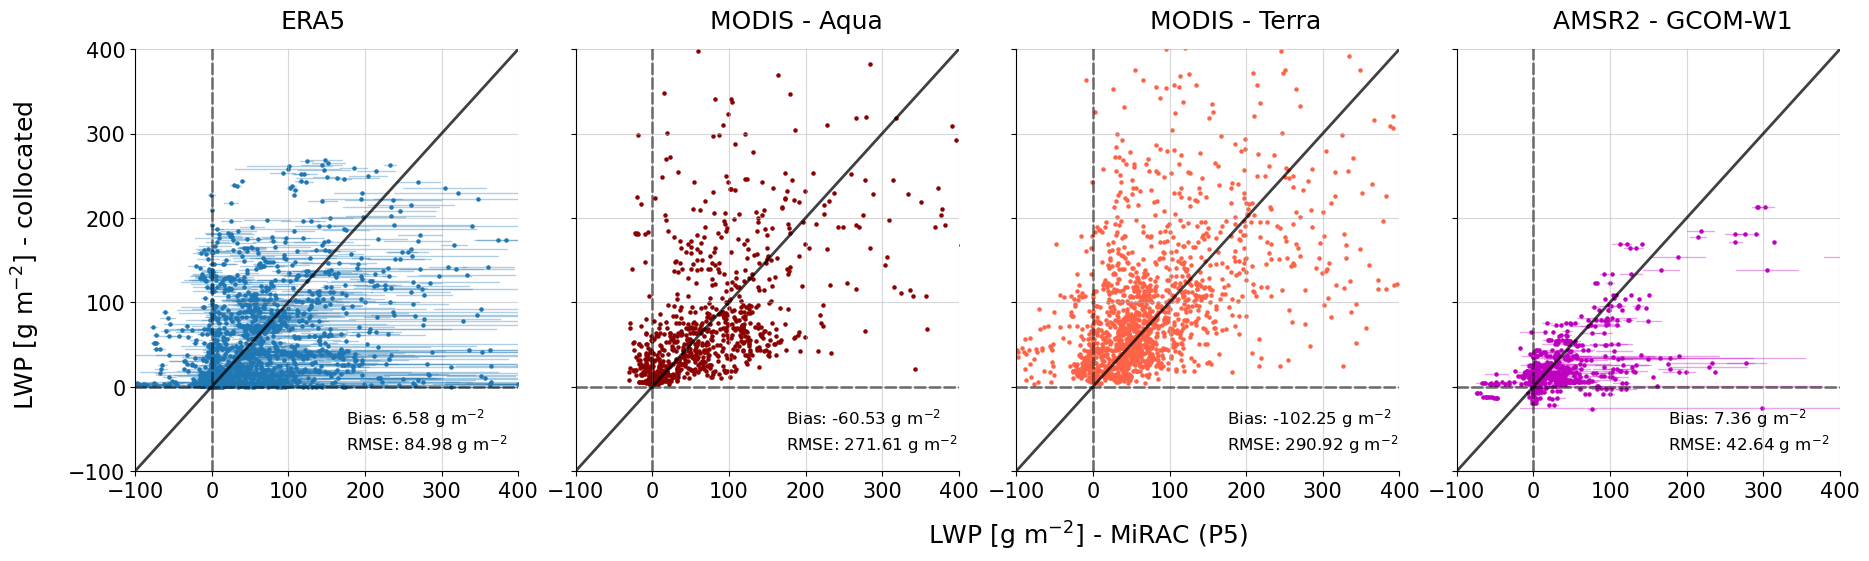

In [15]:
fig, axs = plt.subplots(1,4,figsize=(18,5),sharey=True)

plt.setp(axs, xlim=(-100,400), ylim=(-100,400))

x = era5_p5.lwp_p5_mean.values*1000
x_std = era5_p5.lwp_p5_std.values*1000
y = era5_p5.lwp_era5.values*1000

bias = np.round(np.nanmean(x)-np.nanmean(y),2)
rmse = np.round(np.sqrt(np.nanmean((x-y)**2)),2)

axs[0].scatter(x,y,s=5,label='ERA5',color=colors[0])
axs[0].plot((x-x_std,x+x_std),(y,y),linestyle='-',linewidth=1,color=colors[0],alpha=0.35)
axs[0].grid(alpha=0.5)
axs[0].plot((-100,400), (-100,400), 'k-', alpha=0.75)
axs[0].text(0.38,1.05,'ERA5',transform=axs[0].transAxes)
axs[0].text(0.55,0.05,f'Bias: {bias} '+'g m$^{-2}$'+f'\nRMSE: {rmse} '+'g m$^{-2}$',fontsize=12,transform=axs[0].transAxes)
axs[0].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
axs[0].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

x = lwp_campaign_p5.sel(time=lwp_campaign_aqua.time).lwp.values*1000
y = lwp_aqua

bias = np.round(np.nanmean(x)-np.nanmean(y),2)
rmse = np.round(np.sqrt(np.nanmean((x-y)**2)),2)

axs[1].scatter(x,y,s=5,label='MODIS - Aqua',color=colors[1])
axs[1].grid(alpha=0.5)
axs[1].plot((-100,400), (-100,400), 'k-', alpha=0.75)
axs[1].text(0.35,1.05,'MODIS - Aqua',transform=axs[1].transAxes)
axs[1].text(0.55,0.05,f'Bias: {bias} '+'g m$^{-2}$'+f'\nRMSE: {rmse} '+'g m$^{-2}$',fontsize=12,transform=axs[1].transAxes)
axs[1].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
axs[1].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

x = lwp_campaign_p5.sel(time=lwp_campaign_terra.time).lwp.values*1000
y = lwp_terra

bias = np.round(np.nanmean(x)-np.nanmean(y),2)
rmse = np.round(np.sqrt(np.nanmean((x-y)**2)),2)

axs[2].scatter(x,y,s=5,label='MODIS - Terra',color=colors[2])
axs[2].grid(alpha=0.5)
axs[2].plot((-100,400), (-100,400), 'k-', alpha=0.75)
axs[2].text(0.35,1.05,'MODIS - Terra',transform=axs[2].transAxes)
axs[2].text(0.55,0.05,f'Bias: {bias} '+'g m$^{-2}$'+f'\nRMSE: {rmse} '+'g m$^{-2}$',fontsize=12,transform=axs[2].transAxes)
axs[2].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
axs[2].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

x = amsr_p5.lwp_p5_mean.values*1000
x_std = amsr_p5.lwp_p5_std.values*1000
y = amsr_p5.lwp_amsr.values*1000

bias = np.round(np.nanmean(x)-np.nanmean(y),2)
rmse = np.round(np.sqrt(np.nanmean((x-y)**2)),2)

axs[3].scatter(x,y,s=5,label='AMSR2 - GCOM-W1',color=colors[3])
axs[3].plot((x-x_std,x+x_std),(y,y),linestyle='-',linewidth=1,color=colors[3],alpha=0.35)
axs[3].grid(alpha=0.5)
axs[3].plot((-100,400), (-100,400), 'k-', alpha=0.75)
axs[3].text(0.25,1.05,'AMSR2 - GCOM-W1',transform=axs[3].transAxes)
axs[3].text(0.55,0.05,f'Bias: {bias} '+'g m$^{-2}$'+f'\nRMSE: {rmse} '+'g m$^{-2}$',fontsize=12,transform=axs[3].transAxes)
axs[3].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
axs[3].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

fig.text(0.48, -0.06,'LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=18,va='center')
fig.text(-0.03, 0.5,'LWP [g m$^{-2}$] - collocated',rotation=90,fontsize=18,va='center')

#plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/scatterplot_LWP_P5_vs_all_subplots_v2.png',
#            bbox_inches='tight',
#            dpi=200)

In [9]:
def get_KPIs(x,y):

    nans = np.logical_or(np.isnan(x), np.isnan(y))

    x = x[~nans]
    y = y[~nans]
            
    bias = np.mean(x) - np.mean(y)
    rmse = np.sqrt(np.mean(((x-bias)-y)**2))
    corr = scipy.stats.pearsonr(x,y)[0]

    return np.round(bias,2), np.round(rmse,2), np.round(corr,2)

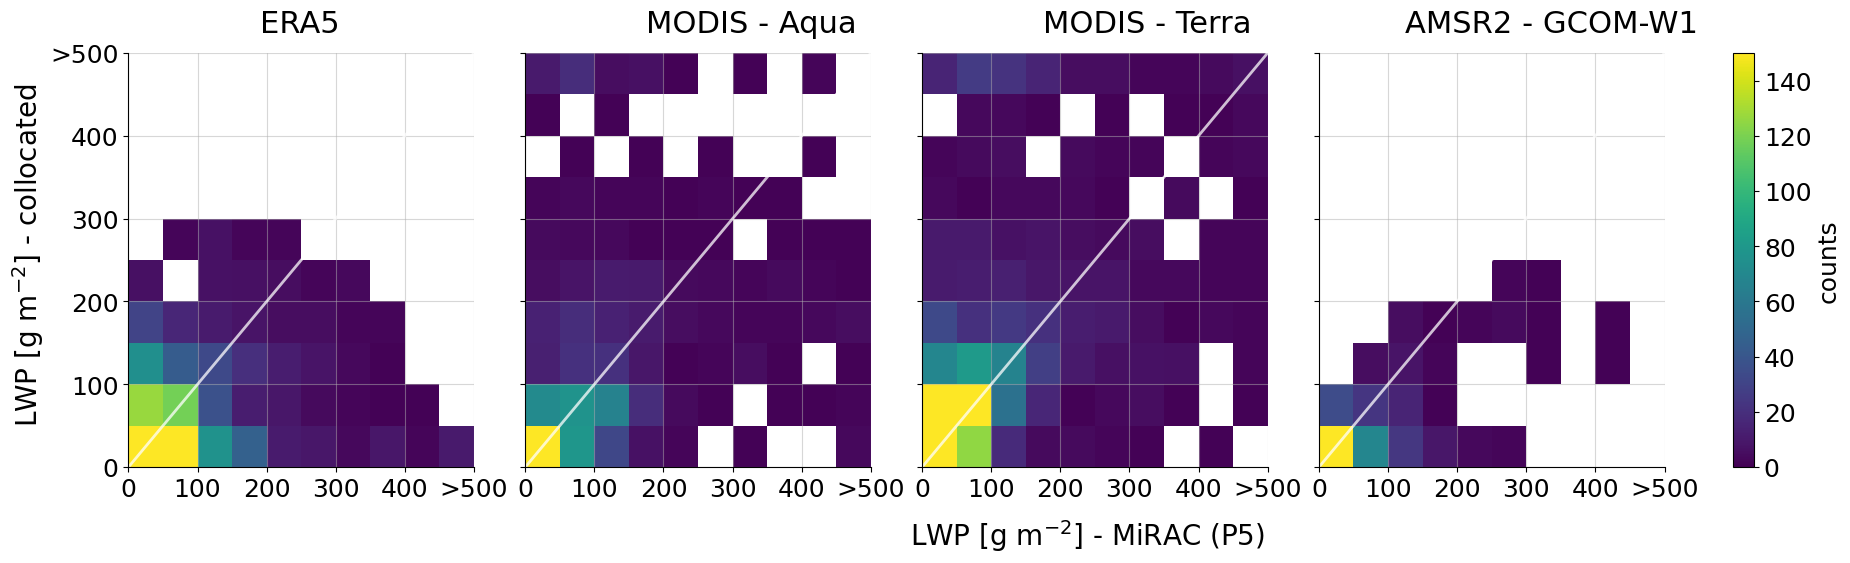

In [21]:
fig, axs = plt.subplots(1,4,figsize=(18,5),sharey=True)

#hist_range = [[-100,500],[-100,500]]
#hist_bins = 12
hist_range = [[0,500],[0,500]]
hist_bins = 10
hist_density = False 
hist_vmin = 0
hist_vmax = 150
hist_cmin = 1

textbox = dict(boxstyle='round', facecolor='white', alpha=0.5)

plt.setp(axs, xlim=(-100,500), ylim=(-100,500))

x = era5_p5.lwp_p5_mean.values*1000
x_std = era5_p5.lwp_p5_std.values*1000
y = era5_p5.lwp_era5.values*1000

bias_era5, rmse_era5, corr_era5 = get_KPIs(x,y)

axs[0].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
              bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[0].grid(alpha=0.5)
axs[0].plot((-100,500), (-100,500), 'white', alpha=0.75)
axs[0].text(0.38,1.05,'ERA5',transform=axs[0].transAxes,fontsize=22)
#axs[0].text(0.55,0.14,f'Bias: {bias_era5} '+'g m$^{-2}$'+f'\nRMSE: {rmse_era5} '+'g m$^{-2}$',fontsize=12,transform=axs[0].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[0].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[0].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[0].set_yticks(np.array([0,100,200,300,400,500]))
axs[0].set_yticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))
axs[0].set_xticks(np.array([0,100,200,300,400,500]))
axs[0].set_xticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))
axs[0].tick_params(axis="both", labelsize=18)


x = lwp_campaign_p5.sel(time=lwp_campaign_aqua.time).lwp.values*1000
y = lwp_aqua

bias_aqua, rmse_aqua, corr_aqua = get_KPIs(x,y)

axs[1].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
              bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[1].grid(alpha=0.5)
axs[1].plot((-100,500), (-100,500), 'white', alpha=0.75)
axs[1].text(0.35,1.05,'MODIS - Aqua',transform=axs[1].transAxes,fontsize=22)
#axs[1].text(0.55,0.14,f'Bias: {bias_aqua} '+'g m$^{-2}$'+f'\nRMSE: {rmse_aqua} '+'g m$^{-2}$',fontsize=12,transform=axs[1].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[1].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[1].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[1].set_xticks(np.array([0,100,200,300,400,500]))
axs[1].set_xticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))
axs[1].tick_params(axis="both", labelsize=18)

x = lwp_campaign_p5.sel(time=lwp_campaign_terra.time).lwp.values*1000
y = lwp_terra

bias_terra, rmse_terra, corr_terra = get_KPIs(x,y)

axs[2].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
              bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[2].grid(alpha=0.5)
axs[2].plot((-100,500), (-100,500), 'black', alpha=0.75)
axs[2].text(0.35,1.05,'MODIS - Terra',transform=axs[2].transAxes,fontsize=22)
#axs[2].text(0.55,0.14,f'Bias: {bias_terra} '+'g m$^{-2}$'+f'\nRMSE: {rmse_terra} '+'g m$^{-2}$',fontsize=12,transform=axs[2].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[2].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[2].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[2].set_xticks(np.array([0,100,200,300,400,500]))
axs[2].set_xticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))
axs[2].tick_params(axis="both", labelsize=18)

x = amsr_p5.lwp_p5_mean.values*1000
x_std = amsr_p5.lwp_p5_std.values*1000
y = amsr_p5.lwp_amsr.values*1000

bias_amsr, rmse_amsr, corr_amsr = get_KPIs(x,y)

hist2d = axs[3].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
                       bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[3].grid(alpha=0.5)
axs[3].plot((-100,500), (-100,500), 'black', alpha=0.75)
axs[3].text(0.25,1.05,'AMSR2 - GCOM-W1',transform=axs[3].transAxes,fontsize=22)
#axs[3].text(0.55,0.14,f'Bias: {bias_amsr} '+'g m$^{-2}$'+f'\nRMSE: {rmse_amsr} '+'g m$^{-2}$',fontsize=12,transform=axs[3].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[3].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[3].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[3].set_xticks(np.array([0,100,200,300,400,500]))
axs[3].set_xticklabels(np.array(['0', '100', '200', '300', '400', '>500']))
axs[3].tick_params(axis="both", labelsize=18) 

cbar = fig.colorbar(hist2d[3],ax=axs[3],pad=0.1,label='counts')
cbar.ax.tick_params(labelsize=18) 

fig.text(0.48, -0.06,'LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=20,va='center')
fig.text(-0.02, 0.5,'LWP [g m$^{-2}$] - collocated',rotation=90,fontsize=20,va='center')

plt.savefig('/home/mringel/lwp_project/figures/figures4poster/2Dhistograms_LWP_P5_vs_all.png',
            bbox_inches='tight',
            dpi=200)

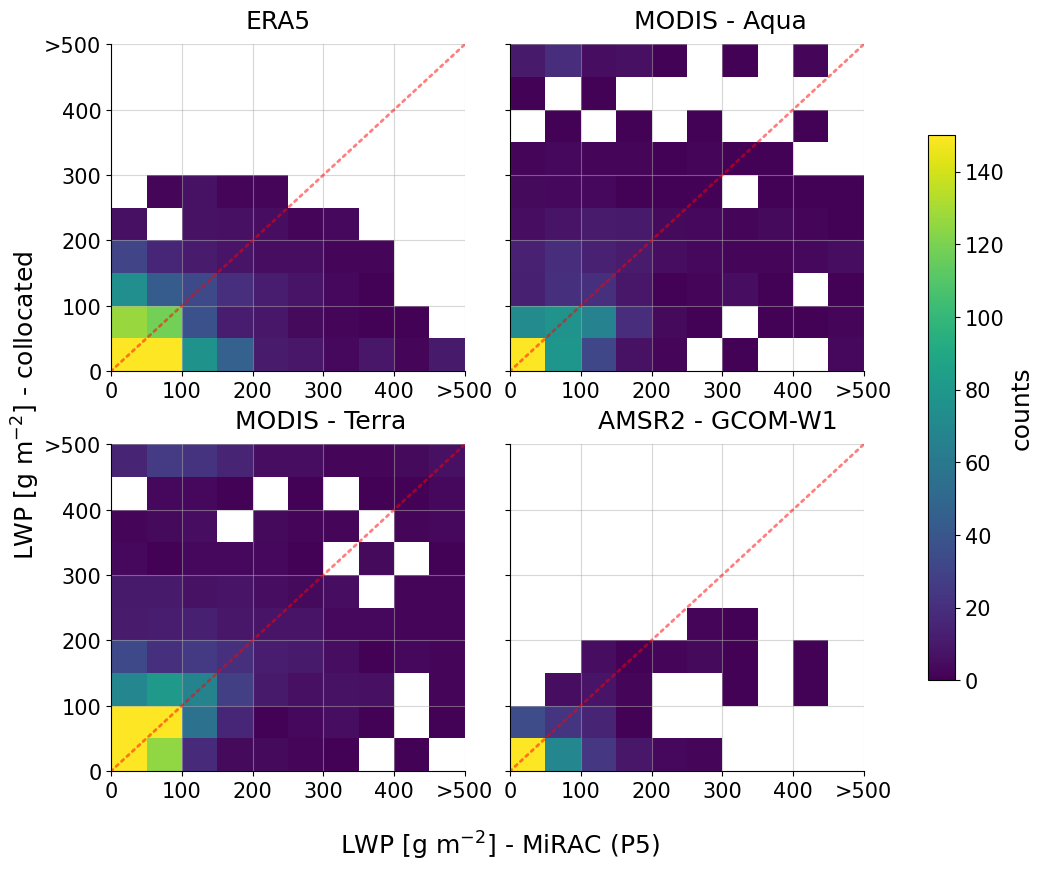

In [40]:
fig, axs = plt.subplots(2,2,figsize=(10,8),sharey=True)

#hist_range = [[-100,500],[-100,500]]
#hist_bins = 12
hist_range = [[0,500],[0,500]]
hist_bins = 10
hist_density = False 
hist_vmin = 0
hist_vmax = 150
hist_cmin = 1

textbox = dict(boxstyle='round', facecolor='white', alpha=0.5)

plt.setp(axs, xlim=(-100,500), ylim=(-100,500))

x = era5_p5.lwp_p5_mean.values*1000
x_std = era5_p5.lwp_p5_std.values*1000
y = era5_p5.lwp_era5.values*1000

bias_era5, rmse_era5, corr_era5 = get_KPIs(x,y)

axs[0,0].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
              bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[0,0].grid(alpha=0.5)
axs[0,0].plot((-100,500), (-100,500), 'red', linestyle=':',alpha=0.5)
axs[0,0].text(0.38,1.05,'ERA5',transform=axs[0,0].transAxes)
#axs[0].text(0.55,0.14,f'Bias: {bias_era5} '+'g m$^{-2}$'+f'\nRMSE: {rmse_era5} '+'g m$^{-2}$',fontsize=12,transform=axs[0].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[0].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[0].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[0,0].set_yticks(np.array([0,100,200,300,400,500]))
axs[0,0].set_yticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))
axs[0,0].set_xticks(np.array([0,100,200,300,400,500]))
axs[0,0].set_xticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))


x = lwp_campaign_p5.sel(time=lwp_campaign_aqua.time).lwp.values*1000
y = lwp_aqua

bias_aqua, rmse_aqua, corr_aqua = get_KPIs(x,y)

axs[0,1].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
              bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[0,1].grid(alpha=0.5)
axs[0,1].plot((-100,500), (-100,500), 'red', linestyle=':', alpha=0.5)
axs[0,1].text(0.35,1.05,'MODIS - Aqua',transform=axs[0,1].transAxes)
#axs[1].text(0.55,0.14,f'Bias: {bias_aqua} '+'g m$^{-2}$'+f'\nRMSE: {rmse_aqua} '+'g m$^{-2}$',fontsize=12,transform=axs[1].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[1].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[1].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[0,1].set_xticks(np.array([0,100,200,300,400,500]))
axs[0,1].set_xticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))

x = lwp_campaign_p5.sel(time=lwp_campaign_terra.time).lwp.values*1000
y = lwp_terra

bias_terra, rmse_terra, corr_terra = get_KPIs(x,y)

axs[1,0].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
              bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[1,0].grid(alpha=0.5)
axs[1,0].plot((-100,500), (-100,500), 'red', linestyle=':', alpha=0.5)
axs[1,0].text(0.35,1.05,'MODIS - Terra',transform=axs[1,0].transAxes)
#axs[2].text(0.55,0.14,f'Bias: {bias_terra} '+'g m$^{-2}$'+f'\nRMSE: {rmse_terra} '+'g m$^{-2}$',fontsize=12,transform=axs[2].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[2].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[2].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[1,0].set_xticks(np.array([0,100,200,300,400,500]))
axs[1,0].set_xticklabels(np.array([ '0', '100', '200', '300', '400', '>500']))

x = amsr_p5.lwp_p5_mean.values*1000
x_std = amsr_p5.lwp_p5_std.values*1000
y = amsr_p5.lwp_amsr.values*1000

bias_amsr, rmse_amsr, corr_amsr = get_KPIs(x,y)

hist2d = axs[1,1].hist2d(np.clip(x,hist_range[0][0],hist_range[0][1]),np.clip(y,hist_range[0][0],hist_range[0][1]),
                       bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
axs[1,1].grid(alpha=0.5)
axs[1,1].plot((-100,500), (-100,500), 'red', linestyle=':', alpha=0.5)
axs[1,1].text(0.25,1.05,'AMSR2 - GCOM-W1',transform=axs[1,1].transAxes)
#axs[3].text(0.55,0.14,f'Bias: {bias_amsr} '+'g m$^{-2}$'+f'\nRMSE: {rmse_amsr} '+'g m$^{-2}$',fontsize=12,transform=axs[3].transAxes,
#            verticalalignment='top', bbox=textbox)
#axs[3].axvline(x=0,linestyle='dashed',color='white',alpha=0.5)
#axs[3].axhline(y=0,linestyle='dashed',color='white',alpha=0.5)
axs[1,1].set_xticks(np.array([0,100,200,300,400,500]))
axs[1,1].set_xticklabels(np.array(['0', '100', '200', '300', '400', '>500']))

fig.colorbar(hist2d[3],ax=axs[:,1],pad=0.1,shrink=0.75,label='counts')

fig.text(0.3, -0.05,'LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=18,va='center')
fig.text(-0.03, 0.5,'LWP [g m$^{-2}$] - collocated',rotation=90,fontsize=18,va='center')

plt.savefig('/home/mringel/lwp_project/figures/figures4poster/2Dhistograms_LWP_P5_vs_all_v2.png',
            bbox_inches='tight',
            dpi=200)

In [24]:
print('KPIs:')
print('')
print('ERA5')
print('Bias: ',bias_era5)
print('RMSE: ',rmse_era5)
print('Corr: ',corr_era5)
print('')
print('Aqua')
print('Bias: ',bias_aqua)
print('RMSE: ',rmse_aqua)
print('Corr: ',corr_aqua)
print('')
print('Terra')
print('Bias: ',bias_terra)
print('RMSE: ',rmse_terra)
print('Corr: ',corr_terra)
print('')
print('AMSR2')
print('Bias: ',bias_amsr)
print('RMSE: ',rmse_amsr)
print('Corr: ',corr_amsr)



KPIs:

ERA5
Bias:  6.58
RMSE:  84.72
Corr:  0.34

Aqua
Bias:  -42.9
RMSE:  268.21
Corr:  0.14

Terra
Bias:  -71.47
RMSE:  282.0
Corr:  0.24

AMSR2
Bias:  8.41
RMSE:  41.81
Corr:  0.67


### Sorted by product and MCAO index

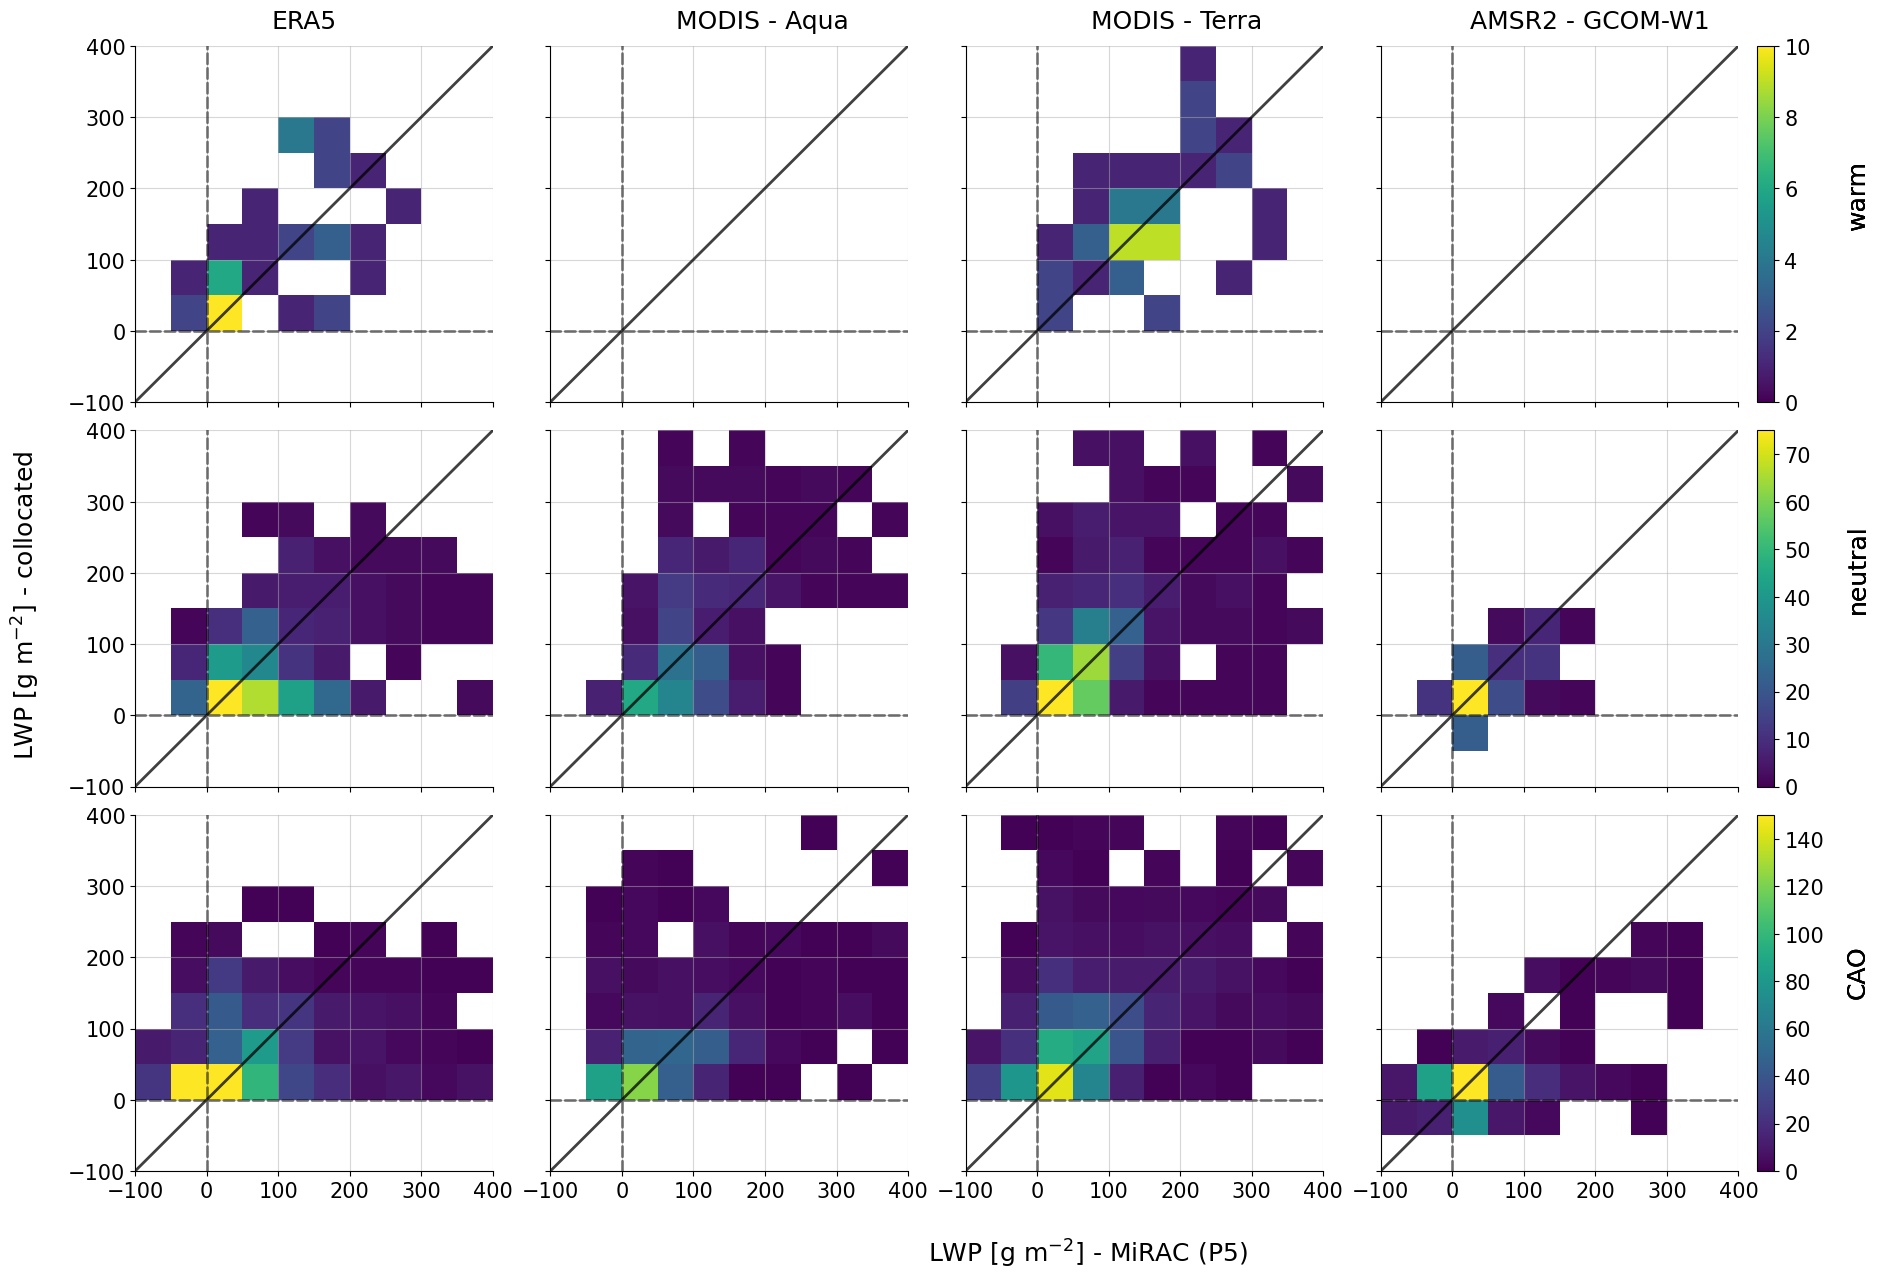

In [91]:
fig, axs = plt.subplots(3,4,figsize=(18,12),sharey=True,sharex=True)

conditions = ['warm','neutral','CAO',]
colors_cond = ['red','grey','blue']
colors = ['C0','darkred','tomato','m','green']

hist_range = [[-100,400],[-100,400]]
hist_bins = 10
hist_density = False 
hist_vmin = 0
hist_cmin = 1


plt.setp(axs, xlim=(-100,400), ylim=(-100,400))

for i,condition in enumerate(conditions):
    
    # Sort by conditions
    if condition == "warm":
        era5_p5_sel = era5_p5.where(era5_p5.mcao_p5_mean<-8.)
        lwp_campaign_aqua_sel = lwp_campaign_aqua.where(mcao.MCAO<-8.)
        lwp_campaign_terra_sel = lwp_campaign_terra.where(mcao.MCAO<-8.)
        amsr_p5_sel = amsr_p5.where(amsr_p5.mcao_p5_mean<-8.)
        hist_vmax = 10

        axs[i,0].text(0.38,1.05,'ERA5',transform=axs[i,0].transAxes)
        axs[i,1].text(0.35,1.05,'MODIS - Aqua',transform=axs[i,1].transAxes)
        axs[i,2].text(0.35,1.05,'MODIS - Terra',transform=axs[i,2].transAxes)
        axs[i,3].text(0.25,1.05,'AMSR2 - GCOM-W1',transform=axs[i,3].transAxes)
    if condition == "neutral":
        era5_p5_sel = era5_p5.where((era5_p5.mcao_p5_mean>=-8.)&(era5_p5.mcao_p5_mean<=0.))
        lwp_campaign_aqua_sel = lwp_campaign_aqua.where((mcao.MCAO>=-8.)&(mcao.MCAO<=0.))
        lwp_campaign_terra_sel = lwp_campaign_terra.where((mcao.MCAO>=-8.)&(mcao.MCAO<=0.))
        amsr_p5_sel = amsr_p5.where((amsr_p5.mcao_p5_mean>=-8.)&(amsr_p5.mcao_p5_mean<=0.))
        hist_vmax = 75
    if condition == "CAO":
        era5_p5_sel = era5_p5.where(era5_p5.mcao_p5_mean>0.)
        lwp_campaign_aqua_sel = lwp_campaign_aqua.where(mcao.MCAO>0.)
        lwp_campaign_terra_sel = lwp_campaign_terra.where(mcao.MCAO>0.)
        amsr_p5_sel = amsr_p5.where(amsr_p5.mcao_p5_mean>0.)
        hist_vmax = 150
    
    axs[0,3].text(1.3,.5,'warm',rotation=90,transform=axs[0,3].transAxes)
    axs[1,3].text(1.3,.5,'neutral',rotation=90,transform=axs[1,3].transAxes)
    axs[2,3].text(1.3,.5,'CAO',rotation=90,transform=axs[2,3].transAxes)

    # ERA5
         
    x = era5_p5_sel.lwp_p5_mean.values*1000
    x_std = era5_p5_sel.lwp_p5_std.values*1000
    y = era5_p5_sel.lwp_era5.values*1000

    axs[i,0].grid(alpha=0.5)
    #axs[i,0].scatter(x,y,s=5,color='C0')
    if (len(x) != 0) and (len(y)!= 0):
        hist2d = axs[i,0].hist2d(x,y,bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
    #fig.colorbar(hist2d[3],ax=axs[i,0])
    #axs[i,0].plot((x-x_std,x+x_std),(y,y),linestyle='-',linewidth=1,color='C0',alpha=0.35)
    axs[i,0].plot((-100,400), (-100,400), 'black', alpha=0.75)
    axs[i,0].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
    axs[i,0].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

    # AQUA

    x = lwp_campaign_p5.sel(time=lwp_campaign_aqua_sel.time).lwp.values*1000
    y = lwp_campaign_aqua_sel.lwp.values

    y[y==-9999] = np.nan
    
    axs[i,1].grid(alpha=0.5)
    #axs[i,1].scatter(x,y,s=5,color='darkred')
    if (len(x) != 0) and (len(y)!= 0):
        hist2d = axs[i,1].hist2d(x,y,bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
    #fig.colorbar(hist2d[3],ax=axs[i,1])
    axs[i,1].plot((-100,400), (-100,400), 'black', alpha=0.75)
    axs[i,1].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
    axs[i,1].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

    # TERRA

    x = lwp_campaign_p5.sel(time=lwp_campaign_terra_sel.time).lwp.values*1000
    y = lwp_campaign_terra_sel.lwp.values

    y[y==-9999] = np.nan
    
    axs[i,2].grid(alpha=0.5)
    #axs[i,2].scatter(x,y,s=5,color='tomato')
    if (len(x) != 0) and (len(y)!= 0):
        hist2d = axs[i,2].hist2d(x,y,bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
    #fig.colorbar(hist2d[3],ax=axs[i,2])
    axs[i,2].plot((-100,400), (-100,400), 'black', alpha=0.75)
    axs[i,2].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
    axs[i,2].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

    # AMSR2

    x = amsr_p5_sel.lwp_p5_mean.values*1000
    x_std = amsr_p5_sel.lwp_p5_std.values*1000
    y = amsr_p5_sel.lwp_amsr.values*1000

    axs[i,3].grid(alpha=0.5)
    #axs[i,3].scatter(x,y,s=5,color='m')
    if (len(x) != 0) and (len(y)!= 0):
        hist2d = axs[i,3].hist2d(x,y,bins=hist_bins,range=hist_range,density=hist_density,vmin=hist_vmin,vmax=hist_vmax,cmin=hist_cmin)
    fig.colorbar(hist2d[3],ax=axs[i,3],pad=-0.3)
    #axs[i,3].plot((x-x_std,x+x_std),(y,y),linestyle='-',linewidth=1,color='m',alpha=0.35)
    axs[i,3].plot((-100,400), (-100,400), 'black', alpha=0.75)
    axs[i,3].axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
    axs[i,3].axhline(y=0,linestyle='dashed',color='black',alpha=0.5)

fig.text(0.48, -0.04,'LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=18,va='center')
fig.text(-0.03, 0.5,'LWP [g m$^{-2}$] - collocated',rotation=90,fontsize=18,va='center')

#plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/scatterplot_LWP_P5_vs_all_subplots_mcao_v3.png',
 #           bbox_inches='tight',
 #           dpi=200)

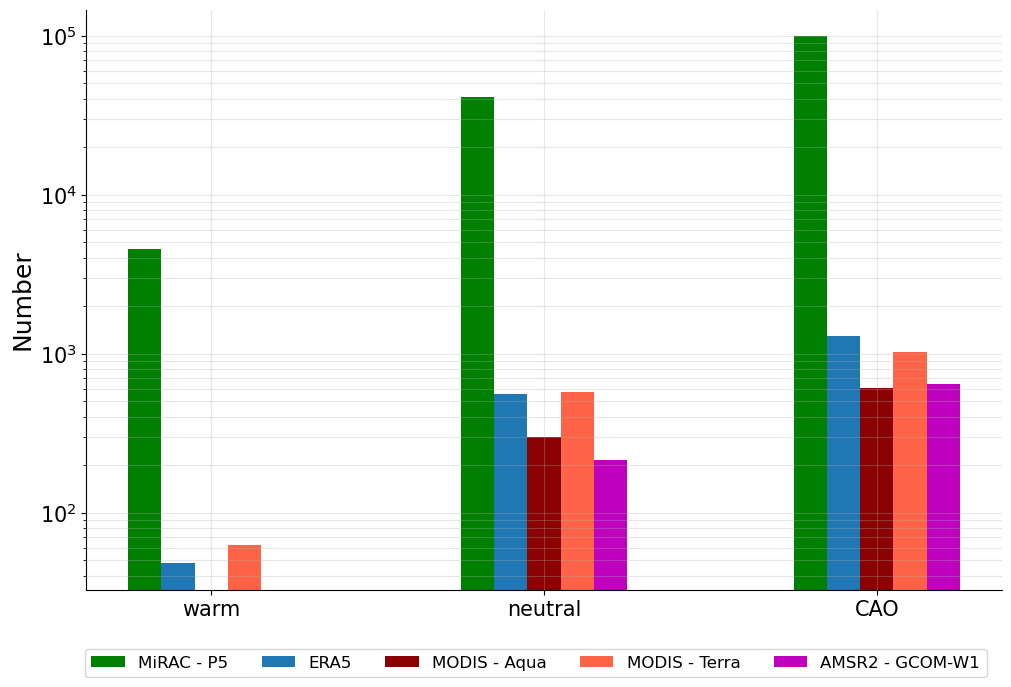

In [25]:
fig, ax = plt.subplots()

X = np.arange(3)
width = 0.1

conditions = ['warm','neutral','CAO']

for i,condition in enumerate(conditions):
    
    # Sort by conditions
    if condition == "warm":
       p5_sel = lwp_campaign_p5.where(mcao.MCAO<-8.)
       era5_p5_sel = era5_p5.where(era5_p5.mcao_p5_mean<-8.)
       lwp_campaign_aqua_sel = lwp_campaign_aqua.where(mcao.MCAO<-8.)
       lwp_campaign_terra_sel = lwp_campaign_terra.where(mcao.MCAO<-8.)
       amsr_p5_sel = amsr_p5.where(amsr_p5.mcao_p5_mean<-8.)

       warm_counts = [
              len(p5_sel.lwp.values[~np.isnan(p5_sel.lwp.values)]),
              len(era5_p5_sel.lwp_era5.values[~np.isnan(era5_p5_sel.lwp_era5.values)]),
              len(lwp_campaign_aqua_sel.lwp.values[~np.isnan(lwp_campaign_aqua_sel.lwp.values)]),
              len(lwp_campaign_terra_sel.lwp.values[~np.isnan(lwp_campaign_terra_sel.lwp.values)]),
              len(amsr_p5_sel.lwp_amsr.values[~np.isnan(amsr_p5_sel.lwp_amsr.values)])]

    if condition == "neutral":
       p5_sel = lwp_campaign_p5.where((mcao.MCAO>=-8.)&(mcao.MCAO<=0.))
       era5_p5_sel = era5_p5.where((era5_p5.mcao_p5_mean>=-8.)&(era5_p5.mcao_p5_mean<=0.))
       lwp_campaign_aqua_sel = lwp_campaign_aqua.where((mcao.MCAO>=-8.)&(mcao.MCAO<=0.))
       lwp_campaign_terra_sel = lwp_campaign_terra.where((mcao.MCAO>=-8.)&(mcao.MCAO<=0.))
       amsr_p5_sel = amsr_p5.where((amsr_p5.mcao_p5_mean>=-8.)&(amsr_p5.mcao_p5_mean<=0.))

       neutral_counts = [
              len(p5_sel.lwp.values[~np.isnan(p5_sel.lwp.values)]),
              len(era5_p5_sel.lwp_era5.values[~np.isnan(era5_p5_sel.lwp_era5.values)]),
              len(lwp_campaign_aqua_sel.lwp.values[~np.isnan(lwp_campaign_aqua_sel.lwp.values)]),
              len(lwp_campaign_terra_sel.lwp.values[~np.isnan(lwp_campaign_terra_sel.lwp.values)]),
              len(amsr_p5_sel.lwp_amsr.values[~np.isnan(amsr_p5_sel.lwp_amsr.values)])]

    if condition == "CAO":
       p5_sel = lwp_campaign_p5.where(mcao.MCAO>0.)
       era5_p5_sel = era5_p5.where(era5_p5.mcao_p5_mean>0.)
       lwp_campaign_aqua_sel = lwp_campaign_aqua.where(mcao.MCAO>0.)
       lwp_campaign_terra_sel = lwp_campaign_terra.where(mcao.MCAO>0.)
       amsr_p5_sel = amsr_p5.where(amsr_p5.mcao_p5_mean>0.)

       cao_counts = [
              len(p5_sel.lwp.values[~np.isnan(p5_sel.lwp.values)]),
              len(era5_p5_sel.lwp_era5.values[~np.isnan(era5_p5_sel.lwp_era5.values)]),
              len(lwp_campaign_aqua_sel.lwp.values[~np.isnan(lwp_campaign_aqua_sel.lwp.values)]),
              len(lwp_campaign_terra_sel.lwp.values[~np.isnan(lwp_campaign_terra_sel.lwp.values)]),
              len(amsr_p5_sel.lwp_amsr.values[~np.isnan(amsr_p5_sel.lwp_amsr.values)])]

CWTs = ['warm',' neutral','CAO']
labels = ['MiRAC - P5','ERA5','MODIS - Aqua','MODIS - Terra','AMSR2 - GCOM-W1']
colors = ['green','C0','darkred','tomato','m']

ax.bar(X + 0.00, [warm_counts[0],neutral_counts[0],cao_counts[0]], 
       color = colors[0], width = width, label = labels[0])
ax.bar(X + 1*width, [warm_counts[1],neutral_counts[1],cao_counts[1]], 
       color = colors[1], width = width, label = labels[1])
ax.bar(X + 2*width,  [warm_counts[2],neutral_counts[2],cao_counts[2]], 
       color = colors[2], width = width, label = labels[2])
ax.bar(X + 3*width,  [warm_counts[3],neutral_counts[3],cao_counts[3]], 
       color = colors[3], width = width, label = labels[3])
ax.bar(X + 4*width,  [warm_counts[4],neutral_counts[4],cao_counts[4]], 
       color = colors[4], width = width, label = labels[4])

ax.set_xticks(X + 2*width, conditions)
ax.set_ylabel('Number')
ax.grid(alpha=0.3,which='both',axis="both")

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, prop={'size': 12}, loc='lower center', ncol=5, bbox_to_anchor=(0.53,-0.1))

ax.set_yscale('log')

plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/number_of_collocs_MCAO.png',
            bbox_inches='tight',
            dpi=200)

In [21]:
era5_p5

<xarray.Dataset>
Dimensions:       (era5_cell: 1894)
Coordinates:
  * era5_cell     (era5_cell) <U22 'ACLOUD_P5_RF05_100' ... 'MOSAiC-ACA_P5_RF...
Data variables:
    lwp_era5      (era5_cell) float64 0.1286 0.1303 0.1321 ... 0.1251 0.08197
    lwp_p5_mean   (era5_cell) float64 -0.015 -0.01061 ... 0.0255 0.002847
    lwp_p5_std    (era5_cell) float64 0.006532 0.01033 ... 0.001761 0.01219
    lwp_p5_var    (era5_cell) float64 4.266e-05 0.0001066 ... 3.1e-06 0.0001485
    lwp_p5_min    (era5_cell) float64 -0.02629 -0.02207 ... 0.02232 -0.00926
    lwp_p5_max    (era5_cell) float64 -0.001158 0.05369 ... 0.02843 0.03847
    mcao_p5_mean  (era5_cell) float64 2.14 2.14 2.14 ... -1.644 -1.644 -1.644

In [16]:
P5_N_ds = src.get_ds_at_times_of_CWT(era5_p5,cwt='N')
P5_S_ds = src.get_ds_at_times_of_CWT(lwp_campaign_p5,cwt='S')
P5_cycl_ds = src.get_ds_at_times_of_CWT(lwp_campaign_p5,cwt='cycl')
P5_anticycl_ds = src.get_ds_at_times_of_CWT(lwp_campaign_p5,cwt='anticycl')

era5_N_ds = src.get_identical_times(lwp_campaign_era5,P5_N_ds,drop_others=True)
era5_S_ds = src.get_identical_times(lwp_campaign_era5,P5_S_ds,drop_others=True)
era5_cycl_ds = src.get_identical_times(lwp_campaign_era5,P5_cycl_ds,drop_others=True)
era5_anticycl_ds = src.get_identical_times(lwp_campaign_era5,P5_anticycl_ds,drop_others=True)

aqua_N_ds = src.get_identical_times(lwp_campaign_aqua,P5_N_ds,drop_others=True)
aqua_S_ds = src.get_identical_times(lwp_campaign_aqua,P5_S_ds,drop_others=True)
aqua_cycl_ds = src.get_identical_times(lwp_campaign_aqua,P5_cycl_ds,drop_others=True)
aqua_anticycl_ds = src.get_identical_times(lwp_campaign_aqua,P5_anticycl_ds,drop_others=True)

terra_N_ds = src.get_identical_times(lwp_campaign_terra,P5_N_ds,drop_others=True)
terra_S_ds = src.get_identical_times(lwp_campaign_terra,P5_S_ds,drop_others=True)
terra_cycl_ds = src.get_identical_times(lwp_campaign_terra,P5_cycl_ds,drop_others=True)
terra_anticycl_ds = src.get_identical_times(lwp_campaign_terra,P5_anticycl_ds,drop_others=True)

amsr_N_ds = src.get_identical_times(lwp_campaign_amsr,P5_N_ds,drop_others=True)
amsr_S_ds = src.get_identical_times(lwp_campaign_amsr,P5_S_ds,drop_others=True)
amsr_cycl_ds = src.get_identical_times(lwp_campaign_amsr,P5_cycl_ds,drop_others=True)
amsr_anticycl_ds = src.get_identical_times(lwp_campaign_amsr,P5_anticycl_ds,drop_others=True)

### CWT N

/tmp/ipykernel_3762014/751691578.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [50]
/tmp/ipykernel_3762014/751691578.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [50]
/tmp/ipykernel_3762014/751691578.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2]._sizes = [50]
/tmp/ipykernel_3762014/751691578.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[3]._sizes = [50]


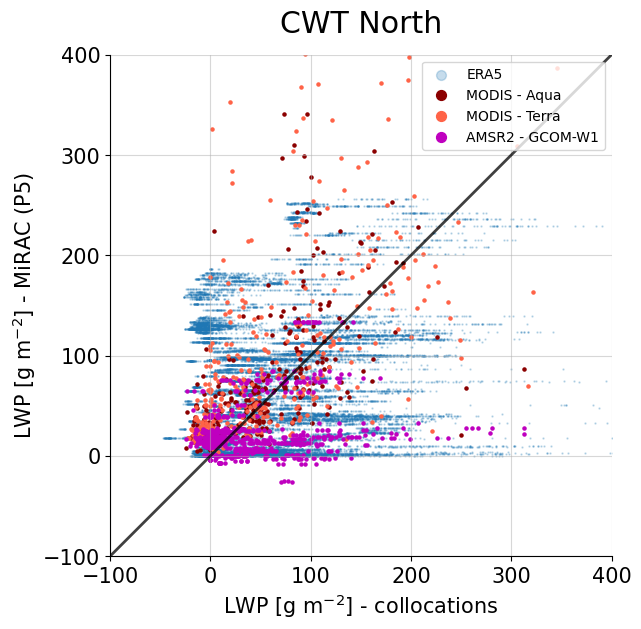

In [84]:
fig, ax = plt.subplots()

fig.suptitle('CWT North')

lwp_p5 = P5_N_ds.lwp.values*1000
lwp_era5 = era5_N_ds.lwp.values*1000
lwp_aqua = aqua_N_ds.lwp.values
lwp_terra = terra_N_ds.lwp.values
lwp_amsr = amsr_N_ds.lwp.values*1000

lwp_terra[lwp_terra==-9999] = np.nan
lwp_aqua[lwp_aqua==-9999] = np.nan
lwp_amsr[lwp_amsr==-9999] = np.nan

ax.scatter(P5_N_ds.sel(time=era5_N_ds.time).lwp.values*1000,lwp_era5,s=0.5,alpha=0.25,label='ERA5',color=colors[0])
ax.scatter(P5_N_ds.sel(time=aqua_N_ds.time).lwp.values*1000,lwp_aqua,s=5,label='MODIS - Aqua',color=colors[1])
ax.scatter(P5_N_ds.sel(time=terra_N_ds.time).lwp.values*1000,lwp_terra,s=5,label='MODIS - Terra',color=colors[2])
ax.scatter(P5_N_ds.sel(time=amsr_N_ds.time).lwp.values*1000,lwp_amsr,s=5,label='AMSR2 - GCOM-W1',color=colors[3])

lgnd = ax.legend(loc='upper right',prop={'size':10})

lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(-100,400)
ax.set_ylim(-100,400)
ax.set_xlabel('LWP [g m$^{-2}$] - collocations',fontsize=15)
ax.set_ylabel('LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=15)
ax.grid(alpha=0.5)

plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/scatterplot_LWP_P5_vs_all_CWT_N.png',
            bbox_inches='tight',
            dpi=200)

/tmp/ipykernel_3762014/2671488868.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [50]
/tmp/ipykernel_3762014/2671488868.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [50]
/tmp/ipykernel_3762014/2671488868.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2]._sizes = [50]
/tmp/ipykernel_3762014/2671488868.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[3]._sizes = [50]


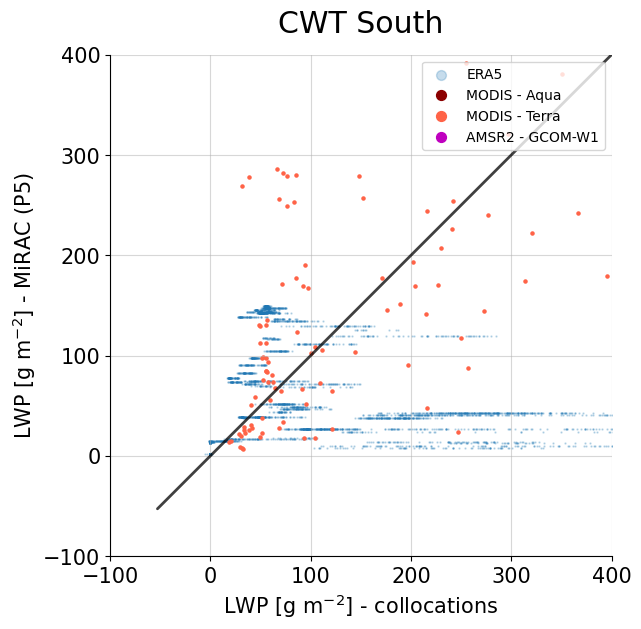

In [85]:
fig, ax = plt.subplots()

fig.suptitle('CWT South')

lwp_p5 = P5_S_ds.lwp.values*1000
lwp_era5 = era5_S_ds.lwp.values*1000
lwp_aqua = aqua_S_ds.lwp.values
lwp_terra = terra_S_ds.lwp.values
lwp_amsr = amsr_S_ds.lwp.values*1000

lwp_terra[lwp_terra==-9999] = np.nan
lwp_aqua[lwp_aqua==-9999] = np.nan
lwp_amsr[lwp_amsr==-9999] = np.nan

ax.scatter(P5_S_ds.sel(time=era5_S_ds.time).lwp.values*1000,lwp_era5,s=0.5,alpha=0.25,label='ERA5',color=colors[0])
ax.scatter(P5_S_ds.sel(time=aqua_S_ds.time).lwp.values*1000,lwp_aqua,s=5,label='MODIS - Aqua',color=colors[1])
ax.scatter(P5_S_ds.sel(time=terra_S_ds.time).lwp.values*1000,lwp_terra,s=5,label='MODIS - Terra',color=colors[2])
ax.scatter(P5_S_ds.sel(time=amsr_S_ds.time).lwp.values*1000,lwp_amsr,s=5,label='AMSR2 - GCOM-W1',color=colors[3])

lgnd = ax.legend(loc='upper right',prop={'size':10})

lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(-100,400)
ax.set_ylim(-100,400)
ax.set_xlabel('LWP [g m$^{-2}$] - collocations',fontsize=15)
ax.set_ylabel('LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=15)
ax.grid(alpha=0.5)

plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/scatterplot_LWP_P5_vs_all_CWT_S.png',
            bbox_inches='tight',
            dpi=200)


/tmp/ipykernel_3762014/555897594.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [50]
/tmp/ipykernel_3762014/555897594.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [50]
/tmp/ipykernel_3762014/555897594.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2]._sizes = [50]
/tmp/ipykernel_3762014/555897594.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[3]._sizes = [50]


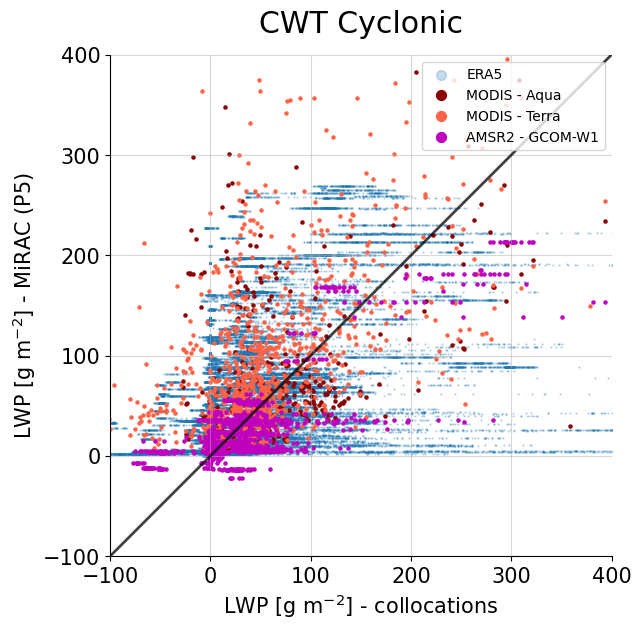

In [86]:
fig, ax = plt.subplots()

fig.suptitle('CWT Cyclonic')

lwp_p5 = P5_cycl_ds.lwp.values*1000
lwp_era5 = era5_cycl_ds.lwp.values*1000
lwp_aqua = aqua_cycl_ds.lwp.values
lwp_terra = terra_cycl_ds.lwp.values
lwp_amsr = amsr_cycl_ds.lwp.values*1000

lwp_terra[lwp_terra==-9999] = np.nan
lwp_aqua[lwp_aqua==-9999] = np.nan
lwp_amsr[lwp_amsr==-9999] = np.nan

ax.scatter(P5_cycl_ds.sel(time=era5_cycl_ds.time).lwp.values*1000,lwp_era5,s=0.5,alpha=0.25,label='ERA5',color=colors[0])
ax.scatter(P5_cycl_ds.sel(time=aqua_cycl_ds.time).lwp.values*1000,lwp_aqua,s=5,label='MODIS - Aqua',color=colors[1])
ax.scatter(P5_cycl_ds.sel(time=terra_cycl_ds.time).lwp.values*1000,lwp_terra,s=5,label='MODIS - Terra',color=colors[2])
ax.scatter(P5_cycl_ds.sel(time=amsr_cycl_ds.time).lwp.values*1000,lwp_amsr,s=5,label='AMSR2 - GCOM-W1',color=colors[3])

lgnd = ax.legend(loc='upper right',prop={'size':10})

lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(-100,400)
ax.set_ylim(-100,400)
ax.set_xlabel('LWP [g m$^{-2}$] - collocations',fontsize=15)
ax.set_ylabel('LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=15)
ax.grid(alpha=0.5)

plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/scatterplot_LWP_P5_vs_all_CWT_cycl.png',
            bbox_inches='tight',
            dpi=200)


/tmp/ipykernel_3762014/2905141122.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [50]
/tmp/ipykernel_3762014/2905141122.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [50]
/tmp/ipykernel_3762014/2905141122.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2]._sizes = [50]
/tmp/ipykernel_3762014/2905141122.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[3]._sizes = [50]


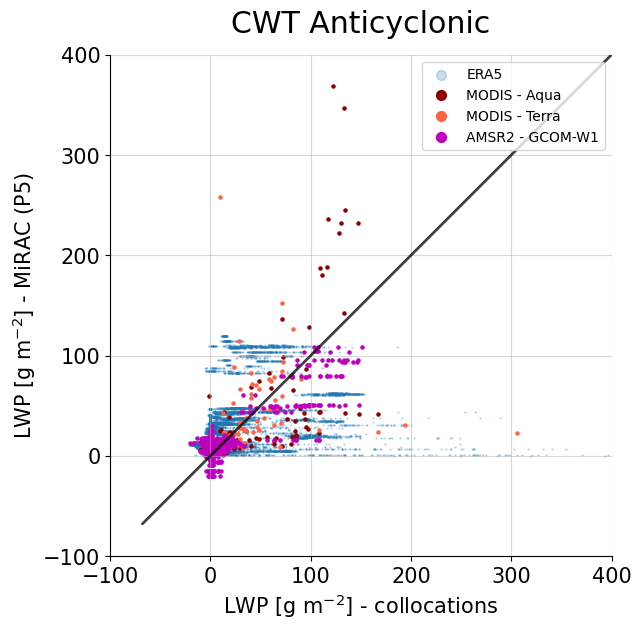

In [87]:
fig, ax = plt.subplots()

fig.suptitle('CWT Anticyclonic')

lwp_p5 = P5_anticycl_ds.lwp.values*1000
lwp_era5 = era5_anticycl_ds.lwp.values*1000
lwp_aqua = aqua_anticycl_ds.lwp.values
lwp_terra = terra_anticycl_ds.lwp.values
lwp_amsr = amsr_anticycl_ds.lwp.values*1000

lwp_terra[lwp_terra==-9999] = np.nan
lwp_aqua[lwp_aqua==-9999] = np.nan
lwp_amsr[lwp_amsr==-9999] = np.nan

ax.scatter(P5_anticycl_ds.sel(time=era5_anticycl_ds.time).lwp.values*1000,lwp_era5,s=0.5,alpha=0.25,label='ERA5',color=colors[0])
ax.scatter(P5_anticycl_ds.sel(time=aqua_anticycl_ds.time).lwp.values*1000,lwp_aqua,s=5,label='MODIS - Aqua',color=colors[1])
ax.scatter(P5_anticycl_ds.sel(time=terra_anticycl_ds.time).lwp.values*1000,lwp_terra,s=5,label='MODIS - Terra',color=colors[2])
ax.scatter(P5_anticycl_ds.sel(time=amsr_anticycl_ds.time).lwp.values*1000,lwp_amsr,s=5,label='AMSR2 - GCOM-W1',color=colors[3])

lgnd = ax.legend(loc='upper right',prop={'size':10})

lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(-100,400)
ax.set_ylim(-100,400)
ax.set_xlabel('LWP [g m$^{-2}$] - collocations',fontsize=15)
ax.set_ylabel('LWP [g m$^{-2}$] - MiRAC (P5)',fontsize=15)
ax.grid(alpha=0.5)

plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/scatterplot_LWP_P5_vs_all_CWT_anticycl.png',
            bbox_inches='tight',
            dpi=200)


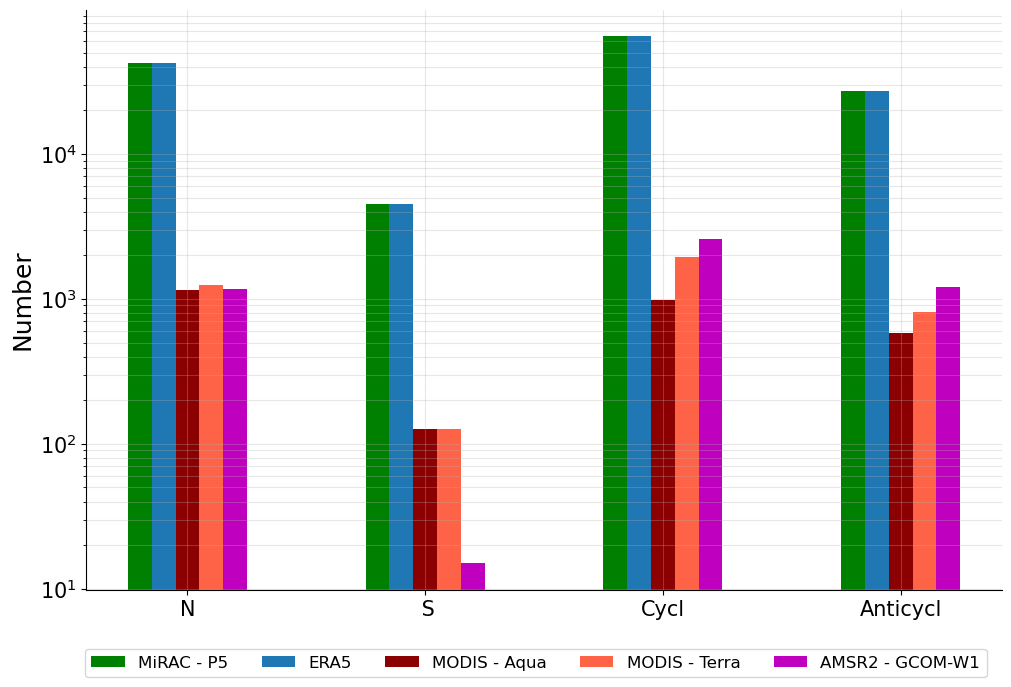

In [18]:
fig, ax = plt.subplots()

X = np.arange(4)
width = 0.1

CWTs = ['N',' S','Cycl','Anticycl']
labels = ['MiRAC - P5','ERA5','MODIS - Aqua','MODIS - Terra','AMSR2 - GCOM-W1']
colors = ['green','C0','darkred','tomato','m']

ax.bar(X + 0.00, [len(P5_N_ds.lwp),len(P5_S_ds.lwp),len(P5_cycl_ds.lwp),len(P5_anticycl_ds.lwp)], 
       color = colors[0], width = width, label = labels[0])
ax.bar(X + 1*width, [len(era5_N_ds.lwp),len(era5_S_ds.lwp),len(era5_cycl_ds.lwp),len(era5_anticycl_ds.lwp)], 
       color = colors[1], width = width, label = labels[1])
ax.bar(X + 2*width,  [len(aqua_N_ds.lwp),len(aqua_S_ds.lwp),len(aqua_cycl_ds.lwp),len(aqua_anticycl_ds.lwp)], 
       color = colors[2], width = width, label = labels[2])
ax.bar(X + 3*width,  [len(terra_N_ds.lwp),len(terra_S_ds.lwp),len(terra_cycl_ds.lwp),len(terra_anticycl_ds.lwp)], 
       color = colors[3], width = width, label = labels[3])
ax.bar(X + 4*width,  [len(amsr_N_ds.lwp),len(amsr_S_ds.lwp),len(amsr_cycl_ds.lwp),len(amsr_anticycl_ds.lwp)], 
       color = colors[4], width = width, label = labels[4])

ax.set_xticks(X + 2*width, CWTs)
ax.set_ylabel('Number')
ax.grid(alpha=0.3,which='both',axis="both")

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, prop={'size': 12}, loc='lower center', ncol=5, bbox_to_anchor=(0.53,-0.1))

ax.set_yscale('log')

#plt.savefig('/home/mringel/lwp_project/figures/cwt_mcao_statistics/number_of_collocs_CWT.png',
#            bbox_inches='tight',
#            dpi=200)